# CNN Implemention on CIFAR-10

In [14]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

ModuleNotFoundError: No module named 'matplotlib_inline'

### Import Dataset and Preprocessing Data

In [4]:
means = [0.5 , 0.5 , 0.5]
stds = [0.5 , 0.5 , 0.5]

dataset_types = ["train" , "test"]

dataset_transforms = {
    "train" : transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= means , std=stds)
    ]),
    "test": transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= means , std=stds)
    ])
}

In [7]:
dataset = {dataset_type : datasets.CIFAR10("./dataset/" , True if dataset_type == "train" else False ,download=True, transform=dataset_transforms[dataset_type]) for dataset_type in dataset_types }


Files already downloaded and verified
Files already downloaded and verified


In [11]:
data_loader = {dataset_type : DataLoader(dataset=dataset[dataset_type] , batch_size=256 , shuffle=True , num_workers=4) for dataset_type in dataset_types}
number_samples = {dataset_type : len(dataset[dataset_type]) for dataset_type in dataset_types }
classes_names = dataset["train"].classes

In [12]:
classes_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
# load one batch
example_data , example_label = next(iter(data_loader["train"]))

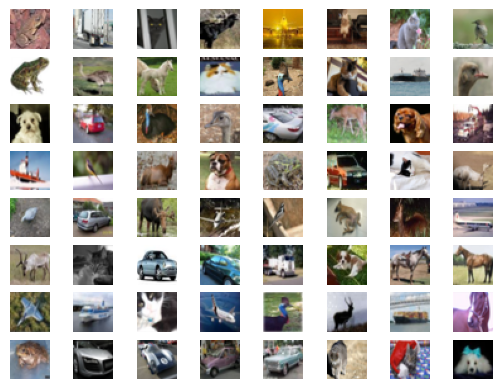

In [21]:
# show some samples
for i in range(64):
    ax = plt.subplot(8,8,i+1)
    ax.axis("off")
    plt.imshow(example_data[i].numpy().transpose((1,2,0)) * stds + means)
plt.savefig("example data.png")
plt.show()

### Create Model

In [41]:
class CNN(nn.Module):
    def __init__(self , input_chanels , output_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_chanels,32,3,2,1)
        self.droupout = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3,2,1)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(64*2*2 , 64 )
        self.linear2 = nn.Linear(64, output_classes)

    def forward(self , x):

        # conv 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # droupout 
        x = self.droupout(x)

        # conv 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # reshape for linear
        x = x.view(-1 , 64*2*2)

        # linear 1
        x = self.linear1(x)
        x = self.relu(x)

        # linear 2
        x = self.linear2(x)

        return x



### define device 

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN(3,10)
model = model.to(device=device)

### define optimizer and loss

In [43]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters() , lr=0.001 ,weight_decay=0.01)

### train model and evalute it

In [45]:
epochs = 50

for epoch in range(epochs):
    correct_train = 0.0
    loss_train = 0.0
    for i , (input , labels) in enumerate(data_loader["train"]):
        input = input.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predicted = model(input)

        loss = criterion(predicted , labels)

        loss.backward()

        optimizer.step()
        with torch.no_grad():
            pred_class = torch.argmax(predicted,1)
            correct_train += torch.sum(labels == pred_class)
            loss_train += loss.item() * len(input)
    with torch.no_grad():
        correct_test = 0.0
        loss_test = 0.0
        for input , labels in data_loader["test"]:
            input = input.to(device)
            labels = labels.to(device)
            predicted = model(input)
            loss = criterion(predicted , labels)
            correct_test +=torch.sum((labels == torch.argmax(predicted,1)))
            loss_test += loss.item() * len(input)
        
        acc_train = correct_train/number_samples["train"]
        acc_test = correct_test/number_samples["test"]
        print(f"Epoch {epoch+1} / {epochs} - train loss= {loss_train:.3f} train accuracy= {acc_train:.2f} - test loss= {loss_test:.3f} test accuracy= {acc_test:.2f} ")
        

Epoch 1 / 50 - train loss= 72482.994 train accuracy= 0.48 - test loss= 14695.611 test accuracy= 0.47 
Epoch 2 / 50 - train loss= 71589.232 train accuracy= 0.49 - test loss= 14561.521 test accuracy= 0.48 
Epoch 3 / 50 - train loss= 70375.938 train accuracy= 0.50 - test loss= 14210.984 test accuracy= 0.49 
Epoch 4 / 50 - train loss= 69741.776 train accuracy= 0.51 - test loss= 13948.414 test accuracy= 0.51 
Epoch 5 / 50 - train loss= 69014.628 train accuracy= 0.51 - test loss= 13745.807 test accuracy= 0.51 
Epoch 6 / 50 - train loss= 68625.922 train accuracy= 0.51 - test loss= 13685.017 test accuracy= 0.52 
Epoch 7 / 50 - train loss= 67759.217 train accuracy= 0.52 - test loss= 13739.537 test accuracy= 0.51 
Epoch 8 / 50 - train loss= 67330.291 train accuracy= 0.52 - test loss= 13414.584 test accuracy= 0.52 
